# Imports

In [1]:
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
import talos
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from time import sleep
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, TimeDistributed, LSTM, Lambda
from tensorflow.keras import regularizers
import tensorflow as tf

Using TensorFlow backend.


# Load data
load hospitalisations and trends for Belgium and France

In [2]:
# topics considered
list_topics = {
    'Fièvre': '/m/0cjf0',
    'Mal de gorge': '/m/0b76bty',
    'Dyspnée': '/m/01cdt5',
    'Agueusie': '/m/05sfr2',
    'Anosmie': '/m/0m7pl',
    'Coronavirus': '/m/01cpyy',
    'Virus': '/m/0g9pc',
    #'Température corporelle humaine': '/g/1213j0cz',
    'Épidémie': '/m/0hn9s',
    'Symptôme': '/m/01b_06',
    'Thermomètre': '/m/07mf1',
    'Grippe espagnole': '/m/01c751',
    'Paracétamol': '/m/0lbt3',
    'Respiration': '/m/02gy9_',
    'Toux': '/m/01b_21'
}

geocodes = {
    'BE': "Belgique",
    'FR-A': "Alsace-Champagne-Ardenne-Lorraine",
    'FR-B': "Aquitaine-Limousin-Poitou-Charentes",
    'FR-C': "Auvergne-Rhône-Alpes",
    'FR-J': 'Ile-de-France'
}

In [3]:
date_begin = "2020-02-01"

def diff_percentage(list_values):
    new_list_values = [0]
    for i in range(1, len(list_values)):
        diff = list_values[i] - list_values[i-1]
        if diff == 0 or list_values[i] == 0:
            new_list_values.append(0)
        else:
            if list_values[i-1] == 0 and list_values[i] != 0:
                new_list_values.append(1.0)
            else:
                diff = diff / list_values[i-1]
                new_list_values.append(diff)
    # Normalization between 0 and 1
    new_list_values = [(x-min(new_list_values))/(max(new_list_values)-min(new_list_values)) for x in new_list_values]
    return new_list_values
        

def create_dataframe_hospi(hospi_france, hospi_belgium, department_france, geo, percentage=True, total=True):
    """
    Creates the dataframe containing the number of daily new hospitalizations
    with respect to the date and the localisation (FR and BE)
    """
    date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
    departements = pd.read_csv(department_france)
    hospitalisations = pd.read_csv(hospi_france, sep=";", parse_dates=['jour'], date_parser=date_parser)
    hospitalisations = hospitalisations[hospitalisations['sexe'] == 0]  # sex=0: men and women
    data_fr = hospitalisations.join(departements.set_index('departmentCode'), on="dep").groupby(["regionTrends", "jour"],
                                                                                                as_index=False).agg(
        {"hosp": "sum"})
    data_fr = data_fr.rename(columns={"jour": "DATE", "hosp": "HOSP", "regionTrends": "LOC"})
    
    # Belgian data
    data_be = pd.read_csv(hospi_belgium).groupby(["DATE"]).agg({"TOTAL_IN": "sum"}).reset_index().rename(
        columns={"TOTAL_IN": "HOSP"})
    data_be["LOC"] = "BE"
    
    if total:
        data_fr["TOT_HOSP"] = data_fr['HOSP']
        data_be["TOT_HOSP"] = data_be['HOSP']

    # Full data
    full_data = data_fr.append(data_be).set_index(["LOC", "DATE"])
    
    # find smallest date for each loc and highest common date
    smallest = {}
    highest = {}
    for loc, date_current in full_data.index:
        if loc not in smallest or smallest[loc] > date_current:
            smallest[loc] = date_current
        if loc not in highest or highest[loc] < date_current:
            highest[loc] = date_current
        
    highest_date = min(highest.values())
    base_date = datetime.strptime(date_begin, "%Y-%m-%d").date()
    
    # get the same maximum date on all region
    #full_data.index = full_data.index.swaplevel(0, 1)
    #full_data = full_data.sort_index()
    #full_data = full_data.loc[pd.IndexSlice[:highest_date,:,:]]
    #full_data.index = full_data.index.swaplevel(0, 1)

    # Add "fake" data (zeroes before the beginning of the crisis) for each loc
    toadd = []
    for loc, sm in smallest.items():
        end = sm.date()
        cur = base_date

        while cur != end:
            toadd.append([cur, loc, 0])
            cur += timedelta(days=1)
            
    full_data = pd.DataFrame(toadd, columns=["DATE", "LOC", "HOSP"]).append(full_data.reset_index()).set_index(
        ["LOC", "DATE"])
    data_dic = {}
    max_date = base_date
    for k, v in geo.items():
        data_dic[k] = full_data.iloc[full_data.index.get_level_values('LOC') == k]
        if percentage:
            #new_list_hospi = diff_percentage(data_dic[k]['HOSP'])
            #data_dic[k]['HOSP'] = new_list_hospi
            data_dic[k]['HOSP'] = data_dic[k]['HOSP'].pct_change()
        data_dic[k]['TOT_HOSP'] = data_dic[k]['TOT_HOSP'].fillna(0.0)
    
    return data_dic


def create_df_trends(url_trends, geo, percentage=True, total=True):
    """
    return dic of {geo: df} for the trends
    """
    date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
    renaming = {v: k for k, v in list_topics.items()}  # change topic_mid to topic_title in the dataframe
    result = {}
    for k, v in geo.items():
        all_trends = []
        for term in list_topics.keys():
            path = f"{url_trends}{k}-{term}.csv"
            encoded_path = requests.get(path).content
            df_trends = pd.read_csv(io.StringIO(encoded_path.decode("utf-8")),
                                    parse_dates=['date'], date_parser=date_parser
                                   ).rename(columns={"date": "DATE"})
            df_trends['LOC'] = k
            df_trends.rename(columns=renaming, inplace=True)
            df_trends.set_index(['LOC', 'DATE'], inplace=True)
            if total:
                df_trends[f"total_{term}"] = df_trends[term]
            if percentage:
                new_list_trends = diff_percentage(df_trends[term])
                df_trends[term] = new_list_trends
            all_trends.append(df_trends)
        result[k] = pd.concat(all_trends, axis=1)
    return result

--------------------BE-----------------------


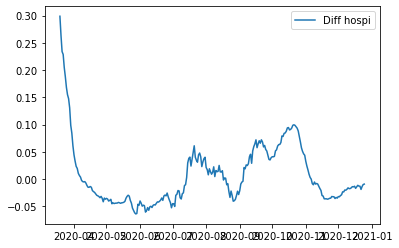

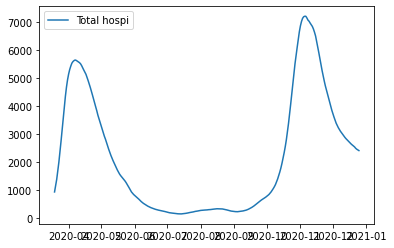

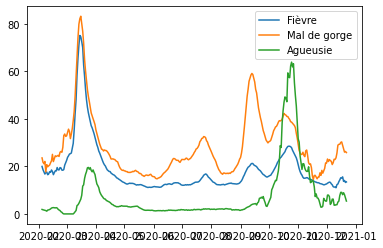

--------------------FR-A-----------------------


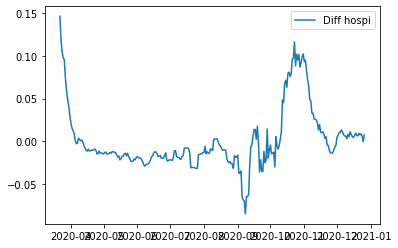

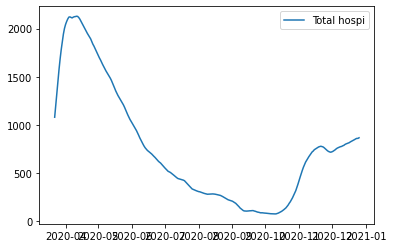

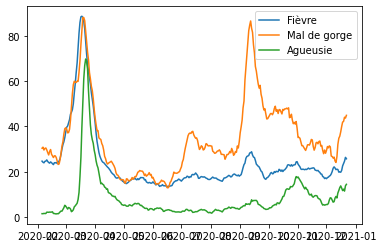

--------------------FR-B-----------------------


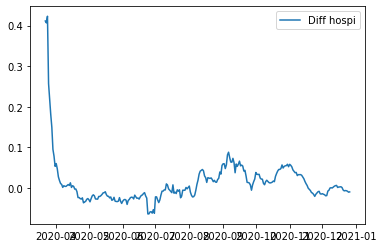

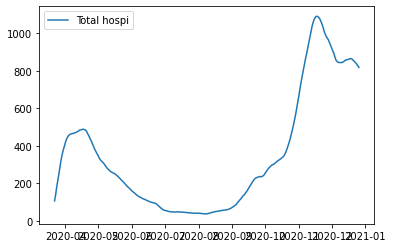

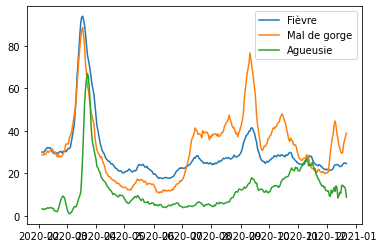

--------------------FR-C-----------------------


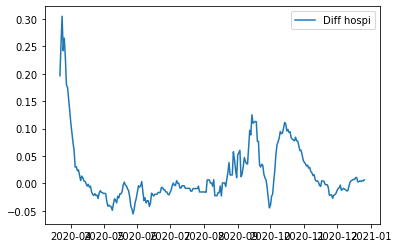

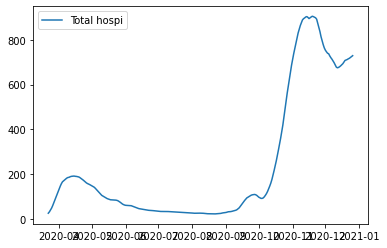

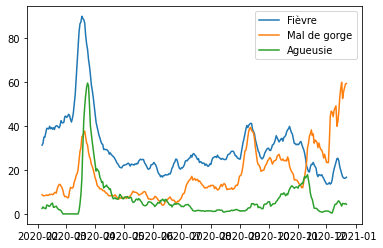

--------------------FR-J-----------------------


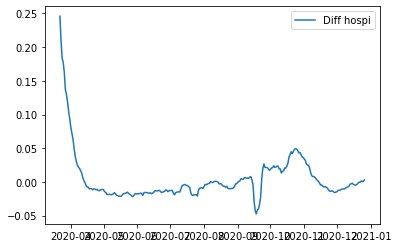

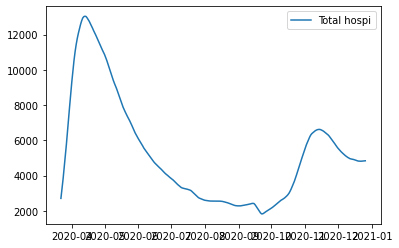

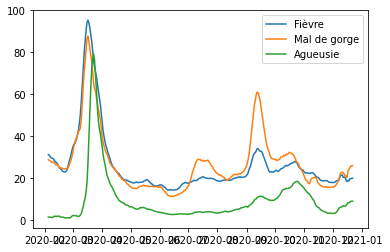

In [4]:
url_trends = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/trends/model/"
url_hospi_belgium = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/be-covid-hospi.csv"
url_department_france = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/src/france_departements.csv"
url_hospi_france = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/fr-covid-hospi-total.csv"
# Percentage is True if we want to take the difference of variation between today and yesterday in percentage
# Total is True if we want to add the absolute total value to the input of the model
df_trends = create_df_trends(url_trends, geocodes, percentage=False, total=False)
df_hospi = create_dataframe_hospi(url_hospi_france, url_hospi_belgium, url_department_france, geocodes, percentage=True, total=True)
for k in geocodes.keys():
    # Rolling average of 7 days 
    df_hospi[k] = df_hospi[k].rolling(7, center=True).mean().dropna()
    df_trends[k] = df_trends[k].rolling(7, center=True).mean().dropna()
    print(f"--------------------{k}-----------------------")
    plt.figure()
    plt.plot(df_hospi[k]['HOSP'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Diff hospi')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(df_hospi[k]['TOT_HOSP'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Total hospi')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(df_trends[k]['Fièvre'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Fièvre')
    plt.plot(df_trends[k]['Mal de gorge'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Mal de gorge')
    plt.plot(df_trends[k]['Agueusie'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Agueusie')
    plt.legend()
    plt.show()

#df_hospi

In [5]:
df_trends['BE']

Fièvre  Mal de gorge    Dyspnée  Agueusie   Anosmie  \
LOC DATE                                                                 
BE  2020-02-04  19.969895     23.555261  21.522456  1.884188  2.017146   
    2020-02-05  18.600817     21.739491  24.965976  1.735412  2.017146   
    2020-02-06  17.625977     21.109361  25.187223  1.639691  2.017146   
    2020-02-07  16.751487     22.071138  24.459801  1.570520  2.017146   
    2020-02-08  17.367931     17.651936  25.185404  1.403598  1.244449   
...                   ...           ...        ...       ...       ...   
    2020-12-18  15.580576     28.824918  33.186641  8.086840  3.185715   
    2020-12-19  13.687943     27.542087  31.951183  8.900246  2.728198   
    2020-12-20  14.080915     25.986105  32.381552  8.069943  3.271215   
    2020-12-21  13.227469     26.262829  30.807473  6.770139  3.052153   
    2020-12-22  13.463138     25.805013  30.477417  5.405560  3.529790   

                Coronavirus      Virus   Épidémie   Symptôme  Thermomètre  \
LOC DATE                                                                    
BE  2020-02-04     4.478571  12.992922   9.736075  19.059730     9.977810   
    2020-02-05     4.285714  12.472916  10.019948  19.066996    11.439284   
    2020-02-06     4.085714  11.692908   9.713058  18.565615    11.615273   
    2020-02-07     3.821429  11.057345   8.339727  18.049702    11.446935   
    2020-02-08     3.314286   9.605662   7.373024  17.228600    10.957227   
...                     ...        ...        ...        ...          ...   
    2020-12-18    12.310148   4.406619   6.202793  18.845092    13.092593   
    2020-12-19    12.015634   4.415797   6.049318  19.024416    12.781978   
    2020-12-20    11.923957   4.464909   6.597334  19.067115    12.620602   
    2020-12-21    11.791582   4.572978   6.481987  18.693514    12.775239   
    2020-12-22    11.164854   4.458331   6.711509  18.517841    13.240752   

                Grippe espagnole  Paracétamol  Respiration       Toux  
LOC DATE                                                               
BE  2020-02-04          6.055230    19.353183    31.525955  28.708061  
    2020-02-05          5.677260    19.309182    29.504003  28.404433  
    2020-02-06          4.713052    19.177178    28.034992  26.855928  
    2020-02-07          4.173095    18.891170    28.497153  26.711705  
    2020-02-08          3.656279    19.169845    26.202855  25.406103  
...                          ...          ...          ...        ...  
    2020-12-18          8.889592    16.586885    16.805652  18.772377  
    2020-12-19          8.521560    16.919761    16.875836  19.068867  
    2020-12-20          8.551879    16.760245    16.797856  19.151203  
    2020-12-21          9.655306    16.441345    16.067044  19.456711  
    2020-12-22         10.440925    18.682853    16.629703  20.304219  

[323 rows x 14 columns]

# Preprocess data

## Normalization [0,1]

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
for k in geocodes.keys():
    df_trends[k] = pd.DataFrame(scaler.fit_transform(df_trends[k].values), columns=df_trends[k].columns, index=df_trends[k].index)
    df_hospi[k] = pd.DataFrame(scaler.fit_transform(df_hospi[k].values), columns=df_hospi[k].columns, index=df_hospi[k].index)
df_hospi['BE']

HOSP  TOT_HOSP
LOC DATE                          
BE  2020-03-19  1.000000  0.111190
    2020-03-20  0.902653  0.141749
    2020-03-21  0.821164  0.174934
    2020-03-22  0.806837  0.216764
    2020-03-23  0.740770  0.261866
...                  ...       ...
    2020-12-21  0.140313  0.338820
    2020-12-22  0.123901  0.332115
    2020-12-23  0.138775  0.327388
    2020-12-24  0.148829  0.323813
    2020-12-25  0.150836  0.320380

[282 rows x 2 columns]

## Days used for the forecast
Each forecast is done for `n_forecast` days and uses `n_samples` days before to construct the prediction

In [7]:
n_forecast = 3  # Number of days we want to predict
n_samples = 14  # Number of days used to make the prediction
shift_hospi = 1  # delay between a date and its newest hosp value for this date 
# (ex: 26/10's newest value is for 25/10)
shift_trends = 1  # delay between a date and its newest trends value for this date 

## Add lag

In [8]:
def timeseries_shift(data, lag, dropna=True):
    """
    Changes all columns with their shifted data
    """
    return data.shift(lag).dropna()

for k in geocodes.keys():
    df_hospi[k] = timeseries_shift(df_hospi[k], shift_hospi)
    df_trends[k] = timeseries_shift(df_trends[k], shift_trends)

In [9]:
def timeseries_add_lag(data, lag, dropna=True):
    """
    Adds lagged values to dataframe
    """
    df = pd.DataFrame(data)
    init_columns = df.columns
    columns = [df.shift(i) for i in range(lag-1, 0, -1)]
    renaming = {}  # rename the columns
    delay = lag-1
    for i in range(lag-1):
        for k in init_columns:
            renaming[k] = f'{k}(t-{delay})'
        columns[i].rename(columns=renaming ,inplace=True)
        delay -= 1
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df.dropna() if dropna else df

merged_df = {k: pd.merge(df_hospi[k], df_trends[k], left_index=True, right_index=True).dropna() for k,v in geocodes.items()}

# use the same date interval in all dataframes
min_date = datetime.strptime("1990-12-01", "%Y-%m-%d").date()
max_date = datetime.strptime("2050-12-01", "%Y-%m-%d").date()
for k in merged_df:
    index_date = merged_df[k].index.get_level_values(1)
    min_date = max(min_date, index_date.min())
    max_date = min(max_date, index_date.max())
for k in merged_df:
    merged_df[k] = merged_df[k].loc[pd.IndexSlice[:,min_date:max_date,:]]    

n_features = len(merged_df['BE'].columns)
lagged_df = {}
for k in geocodes.keys():
    lagged_df[k] = timeseries_add_lag(merged_df[k], n_samples)

## Reshape
The data is reshaped in order to obtain the right format for LSTM:

`[nb_samples, timesteps, input_dim]`

In [10]:
# shape format for LSTM: [nb_samples, timesteps, input_dim]
dataset = {}
for k in geocodes.keys():
    dataset[k] = lagged_df[k].values.reshape(lagged_df[k].shape[0], n_samples, n_features)
dataset['BE'].shape

(262, 14, 16)

We want the targets to be always differents. For instance, if we use 2 days of forecast based on 3 days of data and the days are indexed as integers we want to have:
1. `x: [1,2,3]`, `y: [4,5]`
2. `x: [3,4,5]`, `y: [6,7]`
2. `x: [5,6,7]`, `y: [8,9]`

and so on. **But** this is only done for the fitting of the data. For the prediction itself, we will do it with one days of steps. In the end, if we use days 1 to 7 for the fit and want to predict afterwards, it will look like:

- **fit**: 
    1. `x: [1,2,3]`, `y: [4,5]`
    2. `x: [3,4,5]`, `y: [6,7]`
- **prediction**
    1. `x: [5,6,7]`, `y: [8,9]`
    2. `x: [6,7,8]`, `y: [9,10]`
    
    and so on
    
The prediction presents overlaps in order to obtain a real-time tool, that can be actualized every day

In [11]:
# we take all possible dates for y. If not all dates can be taken, the first dates are dropped
first_set = (len(dataset) - 1) % n_forecast
all_x_set = {}
all_y_set = {}
for k in geocodes:
    all_y_set[k] = np.array([ [dataset[k][i+j+1,n_samples-1,0] for j in range(n_forecast)] for i in range(first_set, len(dataset[k])-n_forecast)])
    all_x_set[k] = np.array([ dataset[k][i] for i in range(first_set, len(dataset[k])-n_forecast)])
    all_y_set[k] = all_y_set[k].reshape(len(all_x_set[k]), n_forecast, 1)

In [12]:
dates = [d.to_pydatetime().date() for d in lagged_df['BE'].index.get_level_values(1)]
x_dates = [ dates[i] for i in range(first_set, len(dataset['BE'])-n_forecast)]
y_dates = [ [dates[i+j+1] for j in range(n_forecast)] for i in range(first_set, len(dataset['BE'])-n_forecast)]
print(f'y_dates=\n', y_dates)
print(f'x_dates=\n', x_dates)

y_dates=
 [[datetime.date(2020, 4, 7), datetime.date(2020, 4, 8), datetime.date(2020, 4, 9)], [datetime.date(2020, 4, 8), datetime.date(2020, 4, 9), datetime.date(2020, 4, 10)], [datetime.date(2020, 4, 9), datetime.date(2020, 4, 10), datetime.date(2020, 4, 11)], [datetime.date(2020, 4, 10), datetime.date(2020, 4, 11), datetime.date(2020, 4, 12)], [datetime.date(2020, 4, 11), datetime.date(2020, 4, 12), datetime.date(2020, 4, 13)], [datetime.date(2020, 4, 12), datetime.date(2020, 4, 13), datetime.date(2020, 4, 14)], [datetime.date(2020, 4, 13), datetime.date(2020, 4, 14), datetime.date(2020, 4, 15)], [datetime.date(2020, 4, 14), datetime.date(2020, 4, 15), datetime.date(2020, 4, 16)], [datetime.date(2020, 4, 15), datetime.date(2020, 4, 16), datetime.date(2020, 4, 17)], [datetime.date(2020, 4, 16), datetime.date(2020, 4, 17), datetime.date(2020, 4, 18)], [datetime.date(2020, 4, 17), datetime.date(2020, 4, 18), datetime.date(2020, 4, 19)], [datetime.date(2020, 4, 18), datetime.date(2020, 

## Split into train - test set

In [13]:
datapoints = {loc: (all_x_set[loc], all_y_set[loc]) for loc in geocodes}
print(datapoints['BE'][0].shape)
print(datapoints['BE'][1].shape)
# shape format for LSTM: [nb_samples, timesteps, input_dim]

(258, 14, 16)
(258, 3, 1)


In [14]:
model = Sequential()
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=True))
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=False))
model.add(Dense(n_forecast))
model.compile(loss="mse", optimizer='adam')
print(model.output_shape)

(None, 3)


In [15]:
df_trends['BE']

Fièvre  Mal de gorge   Dyspnée  Agueusie   Anosmie  \
LOC DATE                                                               
BE  2020-02-05  0.140017      0.132098  0.186573  0.029516  0.039957   
    2020-02-06  0.118640      0.105651  0.242538  0.027185  0.039957   
    2020-02-07  0.103419      0.096473  0.246134  0.025686  0.039957   
    2020-02-08  0.089765      0.110482  0.234311  0.024602  0.039957   
    2020-02-09  0.099390      0.046114  0.246104  0.021987  0.024651   
...                  ...           ...       ...       ...       ...   
    2020-12-18  0.063656      0.230098  0.321431  0.141977  0.063104   
    2020-12-19  0.071482      0.208853  0.376143  0.126680  0.063104   
    2020-12-20  0.041931      0.190168  0.356064  0.139422  0.054042   
    2020-12-21  0.048067      0.167505  0.363059  0.126415  0.064798   
    2020-12-22  0.034741      0.171535  0.337476  0.106054  0.060459   

                Coronavirus     Virus  Épidémie  Symptôme  Thermomètre  \
LOC DATE                                                                 
BE  2020-02-05     0.027757  0.128652  0.087603  0.061267     0.014886   
    2020-02-06     0.025472  0.122125  0.091083  0.061366     0.037098   
    2020-02-07     0.023102  0.112333  0.087321  0.054500     0.039773   
    2020-02-08     0.019971  0.104355  0.070487  0.047436     0.037214   
    2020-02-09     0.013963  0.086132  0.058638  0.036192     0.029771   
...                     ...       ...       ...       ...          ...   
    2020-12-18     0.123694  0.017404  0.033056  0.059468     0.072429   
    2020-12-19     0.120540  0.020868  0.044294  0.058328     0.062226   
    2020-12-20     0.117051  0.020984  0.042413  0.060783     0.057505   
    2020-12-21     0.115965  0.021600  0.049130  0.061368     0.055052   
    2020-12-22     0.114396  0.022957  0.047716  0.056252     0.057402   

                Grippe espagnole  Paracétamol  Respiration      Toux  
LOC DATE                                                              
BE  2020-02-05          0.054307     0.139084     0.352060  0.247675  
    2020-02-06          0.049200     0.138309     0.314765  0.243545  
    2020-02-07          0.036170     0.135983     0.287669  0.222485  
    2020-02-08          0.028874     0.130944     0.296194  0.220524  
    2020-02-09          0.021890     0.135854     0.253875  0.202767  
...                          ...          ...          ...       ...  
    2020-12-18          0.076043     0.100370     0.095949  0.102286  
    2020-12-19          0.092609     0.090345     0.080544  0.112547  
    2020-12-20          0.087636     0.096210     0.081839  0.116579  
    2020-12-21          0.088045     0.093399     0.080400  0.117699  
    2020-12-22          0.102956     0.087781     0.066921  0.121854  

[322 rows x 14 columns]

In [16]:
df_trends['FR-B']

Fièvre  Mal de gorge   Dyspnée  Agueusie   Anosmie  \
LOC  DATE                                                               
FR-B 2020-02-05  0.163445      0.230175  0.110508  0.036463  0.004420   
     2020-02-06  0.163722      0.228851  0.120098  0.034839  0.005256   
     2020-02-07  0.163546      0.241215  0.100802  0.030087  0.006903   
     2020-02-08  0.169774      0.231552  0.126603  0.036440  0.007589   
     2020-02-09  0.182024      0.234242  0.133321  0.037001  0.007529   
...                   ...           ...       ...       ...       ...   
     2020-12-18  0.077517      0.240358  0.301514  0.201977  0.095573   
     2020-12-19  0.086639      0.243500  0.316090  0.204530  0.112706   
     2020-12-20  0.094545      0.294501  0.336018  0.193085  0.105251   
     2020-12-21  0.095681      0.318193  0.337255  0.193085  0.107282   
     2020-12-22  0.096447      0.340944  0.337896  0.175498  0.100154   

                 Coronavirus     Virus  Épidémie  Symptôme  Thermomètre  \
LOC  DATE                                                                 
FR-B 2020-02-05     0.024938  0.110699  0.107564  0.106337     0.030716   
     2020-02-06     0.024381  0.105022  0.101858  0.104532     0.039095   
     2020-02-07     0.023922  0.101337  0.098104  0.103781     0.037096   
     2020-02-08     0.023602  0.095722  0.093862  0.100727     0.035641   
     2020-02-09     0.023835  0.090870  0.094717  0.101611     0.036958   
...                      ...       ...       ...       ...          ...   
     2020-12-18     0.008284  0.021365  0.023933  0.090991     0.184847   
     2020-12-19     0.011350  0.034905  0.028527  0.095391     0.193978   
     2020-12-20     0.012080  0.039762  0.028358  0.091905     0.208463   
     2020-12-21     0.012378  0.041276  0.028903  0.094561     0.228385   
     2020-12-22     0.011300  0.041236  0.030872  0.089283     0.251692   

                 Grippe espagnole  Paracétamol  Respiration      Toux  
LOC  DATE                                                              
FR-B 2020-02-05          0.040400     0.110945     0.146488  0.361758  
     2020-02-06          0.037768     0.118655     0.142425  0.365177  
     2020-02-07          0.038436     0.130053     0.126529  0.363865  
     2020-02-08          0.038335     0.130962     0.102051  0.368758  
     2020-02-09          0.039646     0.128777     0.219977  0.394598  
...                           ...          ...          ...       ...  
     2020-12-18          0.059864     0.119019     0.146463  0.212899  
     2020-12-19          0.063780     0.136392     0.133798  0.218946  
     2020-12-20          0.075587     0.129695     0.114811  0.246223  
     2020-12-21          0.079862     0.115433     0.106755  0.284819  
     2020-12-22          0.091518     0.114389     0.104893  0.304883  

[322 rows x 14 columns]

## Real-time prediction

In [17]:
fit_first_days = 250  # use 90 days for the first fit
fit_steps_days = 30  # every 30 days, do a new fit of the data
epochs = 10 # epochs used to train the model

In [18]:
def data_generator(idx):
    """
    yield data points (X,Y) in all possible loc, on the indices provided
    """
    while True:
        for loc in datapoints:
            yield (datapoints[loc][0][idx],
                  datapoints[loc][1][idx])
            
def data_value_region(idx, loc):
    return (datapoints[loc][0][idx], datapoints[loc][1][idx])

In [19]:
all_prediction = {k: [] for k in geocodes}
all_targets = {k: [] for k in geocodes}
fit_used = []
fit_dates_used = []
prediction_dates_used = []
for day_fit in range(fit_first_days, len(all_x_set['BE']), fit_steps_days):
    fit_idx = list(range(0,day_fit,n_forecast))
    fit_used.append(fit_idx)
    
    history = model.fit(data_generator(fit_idx), steps_per_epoch=len(fit_idx), 
                        epochs=epochs, verbose=1, shuffle=False)
    
    max_predict = min(day_fit + fit_steps_days, len(all_x_set['BE']))
    predict_idx = list(range(day_fit, max_predict))
    
    fit_dates_used.append(np.array(y_dates[:max(fit_idx)+1]))
    predict_dates = np.array([y_dates[i] for i in predict_idx])
    prediction_dates_used.append(predict_dates)
    
    for loc in geocodes:
        X,Y = data_value_region(predict_idx, loc)
        prediction = model.predict(X)
        all_prediction[loc].append(prediction)
        all_targets[loc].append(Y)

Epoch 1/10
84/84 [==============================] - 1s 8ms/step - loss: 0.0101
Epoch 2/10
84/84 [==============================] - 1s 8ms/step - loss: 0.0040
Epoch 3/10
84/84 [==============================] - 1s 7ms/step - loss: 0.0033
Epoch 4/10
84/84 [==============================] - 1s 10ms/step - loss: 0.0028
Epoch 5/10
84/84 [==============================] - 1s 7ms/step - loss: 0.0024
Epoch 6/10
84/84 [==============================] - 1s 9ms/step - loss: 0.0021
Epoch 7/10
84/84 [==============================] - 1s 9ms/step - loss: 0.0023
Epoch 8/10
84/84 [==============================] - 1s 9ms/step - loss: 0.0024
Epoch 9/10
84/84 [==============================] - 1s 8ms/step - loss: 0.0017
Epoch 10/10
84/84 [==============================] - 1s 8ms/step - loss: 0.0018


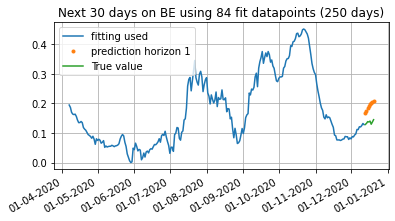

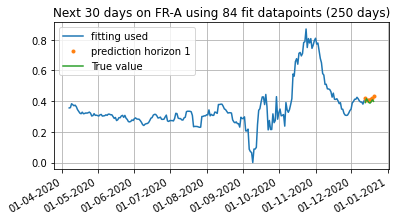

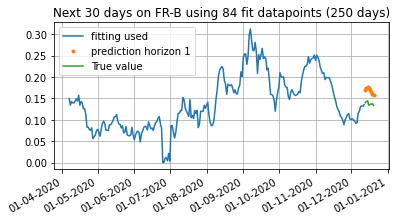

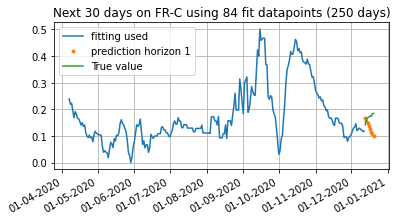

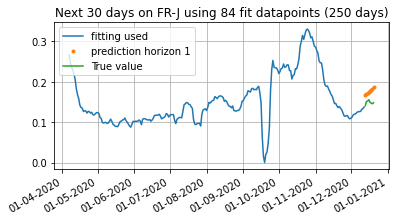

In [20]:
for loc in all_prediction:
    for i, pred in enumerate(all_prediction[loc]):
        prediction = pred
        fit = datapoints[loc][1][:max(fit_used[i])+1][:,0].reshape(-1)
        target = np.array(all_targets[loc][i])
        
        fit_dates = fit_dates_used[i][:,0]
        prediction_dates = prediction_dates_used[i][:,0]
        
        fig = plt.figure(figsize=(6,3))
        plt.plot(fit_dates, fit, label="fitting used")
        plt.plot(prediction_dates, prediction[:,0], '.', label="prediction horizon 1")
        plt.plot(prediction_dates, target[:,0], label="True value")
        
        ax = fig.axes[0]
        # set monthly locator
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        # set formatter
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
        # set font and rotation for date tick labels
        plt.gcf().autofmt_xdate()
        
        plt.legend()
        plt.grid()
        days_used = fit_first_days + i*fit_steps_days
        plt.title(f"Next {fit_steps_days} days on {loc} using {len(fit_used[i])} fit datapoints ({days_used} days)")
        #plt.savefig(f"fit_{len(fit_used[i])}.png", dpi=300)

In [21]:
x_dates

[datetime.date(2020, 4, 6),
 datetime.date(2020, 4, 7),
 datetime.date(2020, 4, 8),
 datetime.date(2020, 4, 9),
 datetime.date(2020, 4, 10),
 datetime.date(2020, 4, 11),
 datetime.date(2020, 4, 12),
 datetime.date(2020, 4, 13),
 datetime.date(2020, 4, 14),
 datetime.date(2020, 4, 15),
 datetime.date(2020, 4, 16),
 datetime.date(2020, 4, 17),
 datetime.date(2020, 4, 18),
 datetime.date(2020, 4, 19),
 datetime.date(2020, 4, 20),
 datetime.date(2020, 4, 21),
 datetime.date(2020, 4, 22),
 datetime.date(2020, 4, 23),
 datetime.date(2020, 4, 24),
 datetime.date(2020, 4, 25),
 datetime.date(2020, 4, 26),
 datetime.date(2020, 4, 27),
 datetime.date(2020, 4, 28),
 datetime.date(2020, 4, 29),
 datetime.date(2020, 4, 30),
 datetime.date(2020, 5, 1),
 datetime.date(2020, 5, 2),
 datetime.date(2020, 5, 3),
 datetime.date(2020, 5, 4),
 datetime.date(2020, 5, 5),
 datetime.date(2020, 5, 6),
 datetime.date(2020, 5, 7),
 datetime.date(2020, 5, 8),
 datetime.date(2020, 5, 9),
 datetime.date(2020, 5, 10)

# Comparison between several models

In [22]:
end_train = "2020-09-15"  # dates with respect to x, included
end_valid = "2020-11-20"
end_test = "2020-12-25"
epochs = 10

date_f = "%Y-%m-%d"
max_dates = [datetime.strptime(end_train, date_f).date(),
            datetime.strptime(end_valid, date_f).date(),
            datetime.strptime(end_test, date_f).date()]
max_dates[-1] = min(max(x_dates), max_dates[-1])
max_train_idx, max_valid_idx, max_test_idx = np.where(np.isin(x_dates, max_dates))[0]

train_idx = list(reversed(range(max_train_idx, -1, -n_forecast)))
valid_idx = list(range(max_train_idx+1, max_valid_idx+1))
test_idx = list(range(max_valid_idx+1, max_test_idx+1))

def train_generator():
    return data_generator(train_idx)

def validation_generator():
    return data_generator(valid_idx)

def test_generator():
    return data_generator(valid_idx)

train_datapoints = {loc: data_value_region(train_idx, loc) for loc in geocodes}
valid_datapoints = {loc: data_value_region(valid_idx, loc) for loc in geocodes}
test_datapoints = {loc: data_value_region(test_idx, loc) for loc in geocodes}

## Toy model

In [23]:
model = Sequential()
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=True))
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=False))
model.add(Dense(n_forecast))
LSTMModel = model
print(model.output_shape)

(None, 3)


In [24]:
#history = model.fit(x_train, y_train, epochs=400, verbose=1, shuffle=False)
LSTMModel.compile(loss="mse", optimizer='adam')
history = LSTMModel.fit(train_generator(), steps_per_epoch=len(fit_idx), epochs=epochs, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_idx))

Epoch 1/10
84/84 [==============================] - 1s 16ms/step - loss: 0.0085 - val_loss: 0.0145
Epoch 2/10
84/84 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0114
Epoch 3/10
84/84 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0111
Epoch 4/10
84/84 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 0.0112
Epoch 5/10
84/84 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0109
Epoch 6/10
84/84 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0107
Epoch 7/10
84/84 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 0.0107
Epoch 8/10
84/84 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 0.0111
Epoch 9/10
84/84 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0084
Epoch 10/10
84/84 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 0.0093


TEST BE
MSE =  0.008145542699058522
MAE =  0.08744524712530105


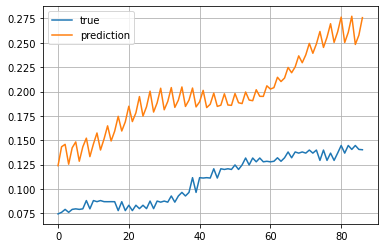

TEST FR-A
MSE =  0.002744181706305646
MAE =  0.04808610256762802


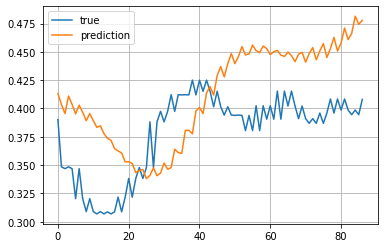

TEST FR-B
MSE =  0.0011854362402024781
MAE =  0.027398968918035588


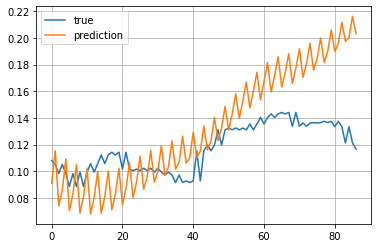

TEST FR-C
MSE =  0.08495469122979457
MAE =  0.2868641943735408


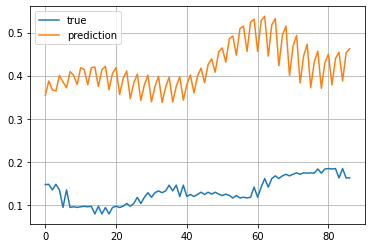

TEST FR-J
MSE =  0.0004029240827812984
MAE =  0.01589113544472624


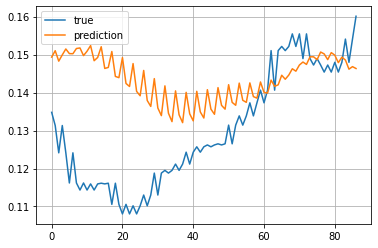

In [25]:
"""for loc in train_datapoints:
    print("TRAINING", loc)
    x, y = train_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()
    
for loc in valid_datapoints:
    print("VALIDATION", loc)
    x, y = valid_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()"""

for loc in test_datapoints:
    MSE = 0
    MAE = 0
    print("TEST", loc)
    x, y = test_datapoints[loc]
    yp = model.predict(x)
    MSE = mean_squared_error(y.reshape(-1), yp.reshape(-1))
    MAE = mean_absolute_error(y.reshape(-1), yp.reshape(-1))
    print("MSE = ", MSE)
    print("MAE = ", MAE)
    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()

In [26]:
# Let's use the validation set

## Base line models
### MultiStepLastBaseline
This model repeats the last value of hospitalisations `n_forecast` time

In [27]:
class MultiStepLastBaseline(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def call(self, inputs):
        a = inputs[:, -1:, :1]  # hospitalisations of the last days
        return tf.tile(
            a,
            [1, n_forecast, 1]   # repeat hospitalisations n_forecast time
        )

BaselineModel = MultiStepLastBaseline()
BaselineModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

## Linear regression
linear regression of the last `n_sample` days used to predict the next `n_forecast` days

In [28]:
class LinearRegressionHospi(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def predict(self, inputs):
        y = inputs[:, :, 0]  # hospitalisations of the last days
        length = len(inputs)
        x = np.arange(n_samples).reshape(-1,1)  # dates of the hospitalisations
        result = np.zeros((length, n_forecast))
        for i in range(length):
            regr = LinearRegression().fit(x,y[i])  # linear regression of (days, hospi)
            result[i] = regr.predict(np.arange(n_samples, n_samples+n_forecast).reshape(-1,1))
        return result
        

## 1 fully connected layer (Dense model)

In [29]:
DenseModel = Sequential()
DenseModel.add(Lambda(lambda x: x[:,:,0]))  # select only the hospitalisations of the previous days
DenseModel.add(Dense(n_forecast))   # predict the next hospitalisations based on the previous ones
DenseModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

In [30]:
LinearModel_history = DenseModel.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=epochs, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_datapoints))

Epoch 1/10
5/5 [==============================] - 0s 14ms/step - loss: 0.0698 - mean_absolute_error: 0.2017 - val_loss: 0.2201 - val_mean_absolute_error: 0.3593
Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0605 - mean_absolute_error: 0.1853 - val_loss: 0.2002 - val_mean_absolute_error: 0.3407
Epoch 3/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0541 - mean_absolute_error: 0.1739 - val_loss: 0.1840 - val_mean_absolute_error: 0.3252
Epoch 4/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0489 - mean_absolute_error: 0.1640 - val_loss: 0.1698 - val_mean_absolute_error: 0.3110
Epoch 5/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0443 - mean_absolute_error: 0.1550 - val_loss: 0.1569 - val_mean_absolute_error: 0.2976
Epoch 6/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0401 - mean_absolute_error: 0.1465 - val_loss: 0.1450 - val_mean_absolute_error: 0.2847
Epoch 7/10
5/5 [=======================

# Comparisons of the models

In [31]:
#LSTMModel = scan_object.best_model(metric='val_mse', asc=True)  # retrieve the best model from the scan
all_models = {
    'RepeatLast': BaselineModel,
    'LSTM': LSTMModel,
    'Dense': DenseModel,
    'Linear regression': LinearRegressionHospi()
}

def error_set(models, points, plot=True):
    y_predicted = {k:[] for k in models.keys()}
    y_true = []
    length = 0
    for loc in points:
        print(loc)
        length += 1
        x, y = points[loc]
        y = y.reshape(-1)
        y_true.extend(y)
        for name, model in models.items():
            yp = model.predict(x)
            yp = yp.reshape(-1)
            if plot:
                plt.plot(y, label='true')
                plt.plot(yp, label='prediction')
                plt.legend()
                plt.grid()
                plt.title(name)
                plt.show()
            y_predicted[name].extend(yp)
    MSE = []
    MAE = []
    models_names = []
    for k in models.keys():
        models_names.append(k)
        MSE.append(mean_squared_error(y_true, y_predicted[k]))
        MAE.append(mean_absolute_error(y_true, y_predicted[k]))
    return pd.DataFrame(data={'Model': models_names, 'MSE': MSE, 'MAE': MAE}).set_index('Model').sort_values(by=['MSE'])

## Training

In [32]:
error_set(all_models, train_datapoints, plot=False)

BE
FR-A
FR-B
FR-C
FR-J


,MSE,MAE
Model,,
RepeatLast,0.001040,0.019756
LSTM,0.001241,0.023801
Linear regression,0.003067,0.035655
Dense,0.025039,0.112688


## Validation

BE


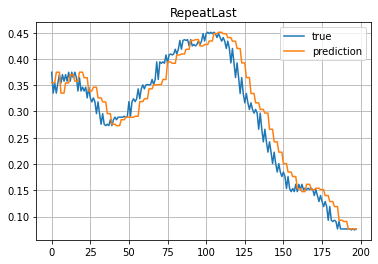

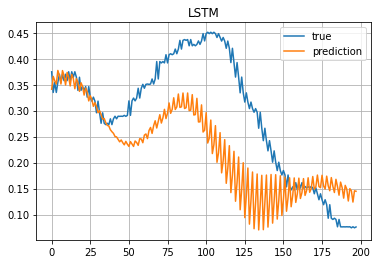

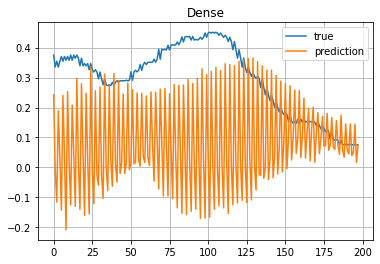

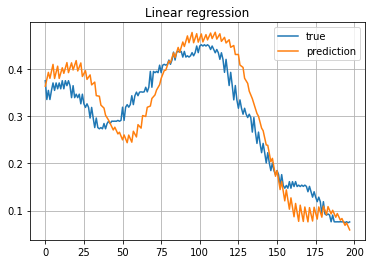

FR-A


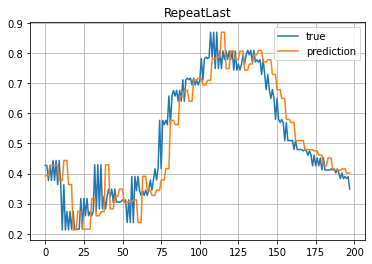

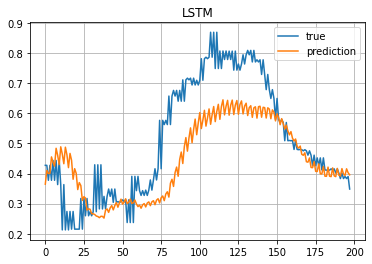

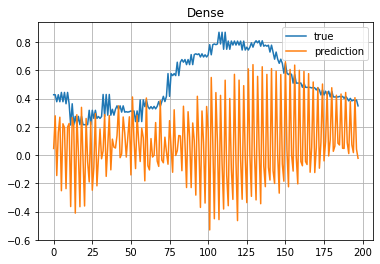

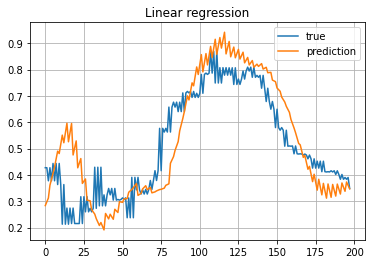

FR-B


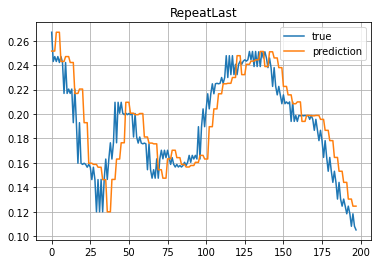

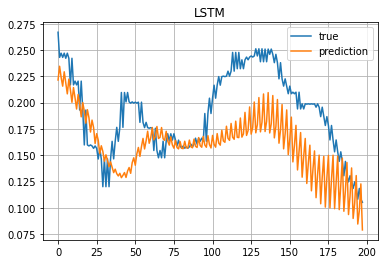

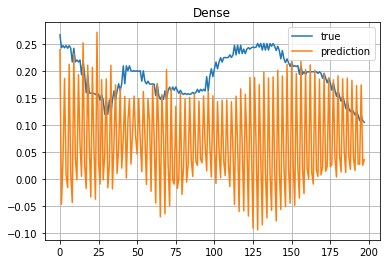

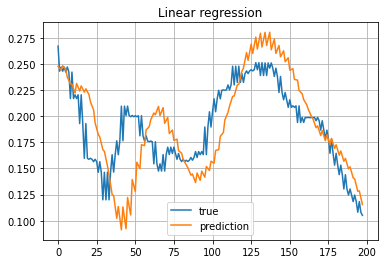

FR-C


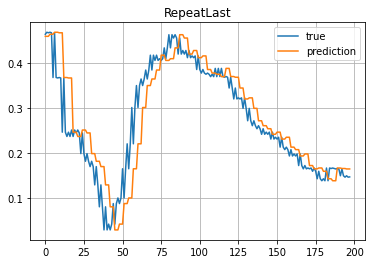

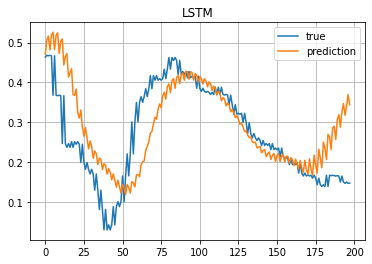

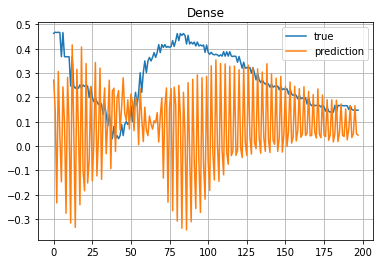

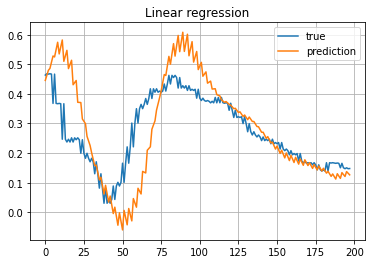

FR-J


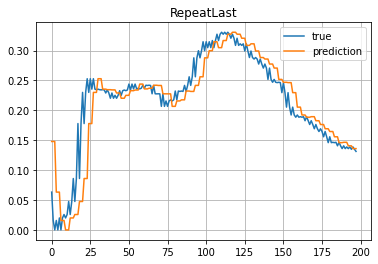

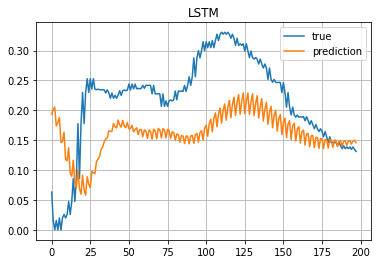

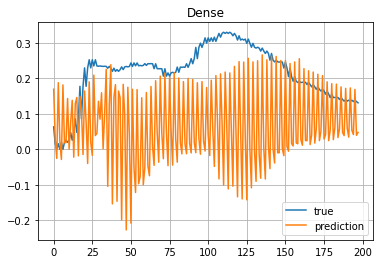

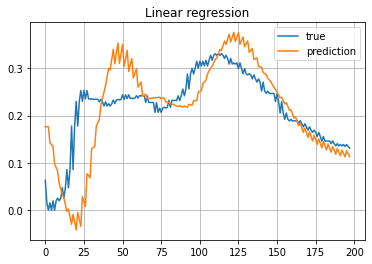

,MSE,MAE
Model,,
RepeatLast,0.002178,0.030443
Linear regression,0.006934,0.055634
LSTM,0.009358,0.071729
Dense,0.105276,0.236600


In [33]:
error_set(all_models, valid_datapoints)

## Test

BE


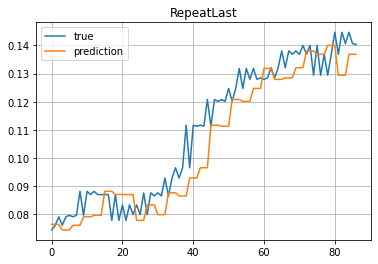

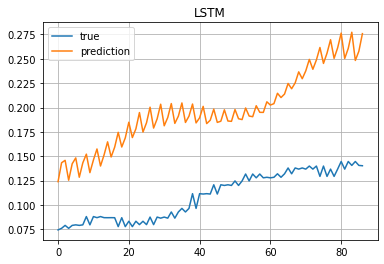

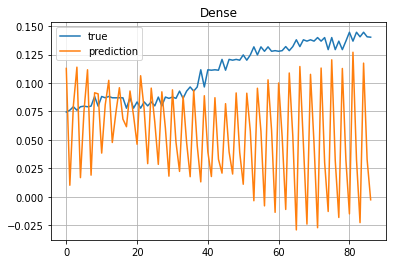

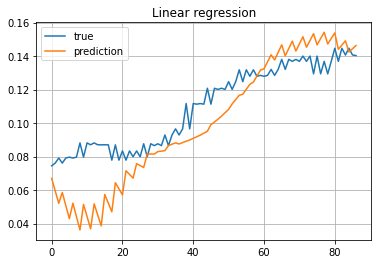

FR-A


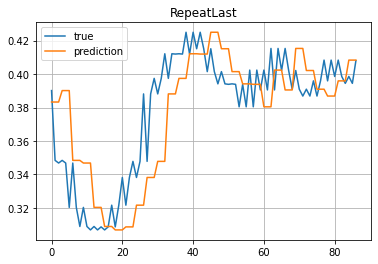

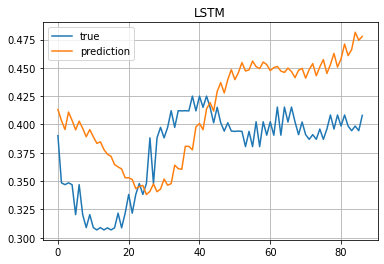

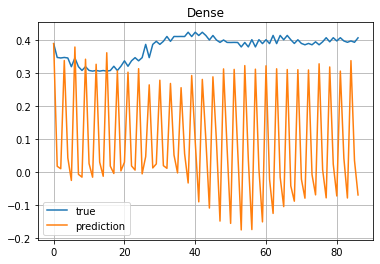

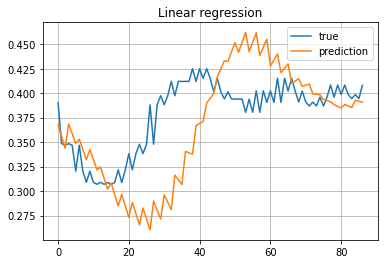

FR-B


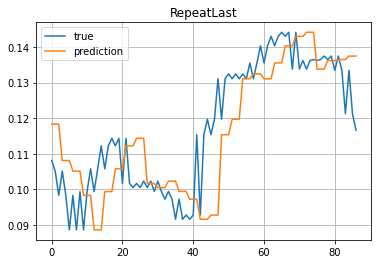

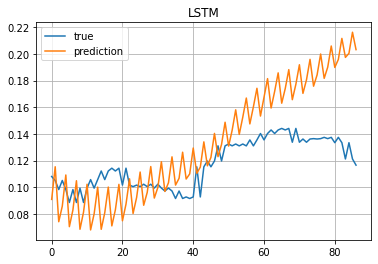

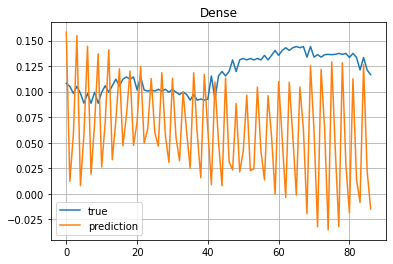

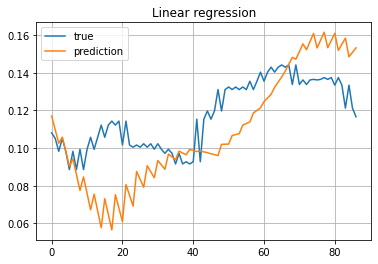

FR-C


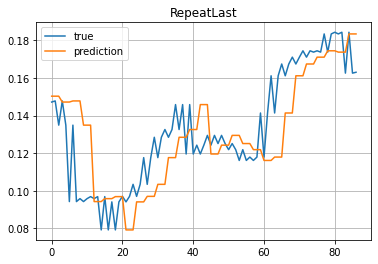

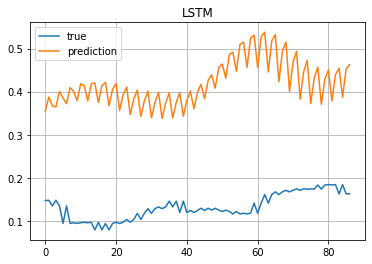

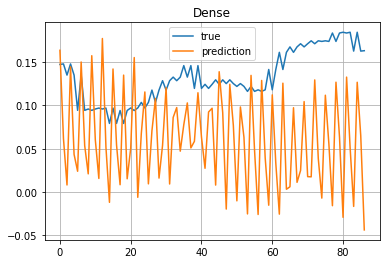

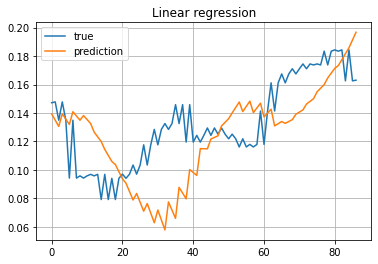

FR-J


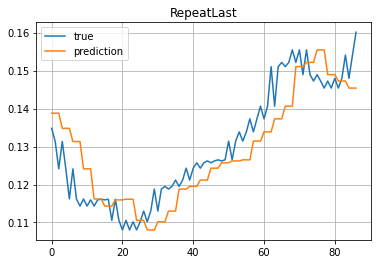

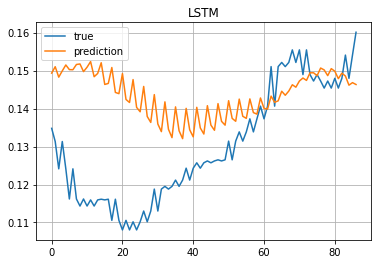

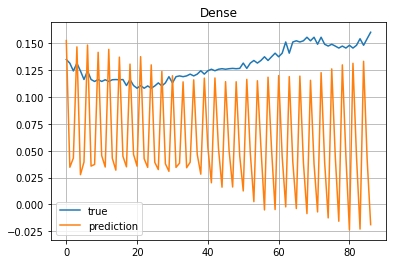

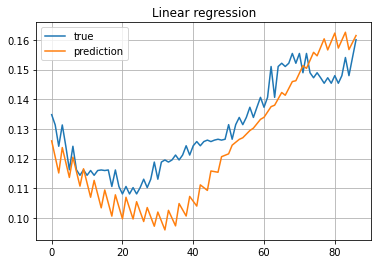

,MSE,MAE
Model,,
RepeatLast,0.000257,0.011142
Linear regression,0.000898,0.021287
LSTM,0.019487,0.093137
Dense,0.028063,0.113284


In [34]:
error_set(all_models, test_datapoints)